In [1]:
import os
import numpy as np
import pandas as pd

**path指定**

In [2]:
base_dir = '/content/drive/MyDrive/kaggle/signLanguage/csv'
train_dir = base_dir + '/train'
test_dir = base_dir + '/test'

#trainのデータ読み込み

In [3]:
# dir内のフォルダ数を数える
folder_count = 0
dir = train_dir
for path in os.listdir(dir):
    if os.path.isdir(os.path.join(dir, path)):
        folder_count += 1
print(folder_count)

20


In [4]:
for i in range(1,folder_count+1):
    exec_command = 'train_sign' + str(i) + "_path = train_dir + '/sign_" + str(i) + "/'"
    exec(exec_command)
    #print(exec_command)

In [5]:
train_sign1_path  # パス確認

'/content/drive/MyDrive/kaggle/signLanguage/csv/train/sign_1/'

In [6]:
frame = 60
Y=[]
for i in range(1,folder_count+1):
    # sign1-sign20のpathを指定
    path_exec_command = 'path = train_sign' + str(i) + '_path'
    exec(path_exec_command)
    #print(path_exec_command)

    files=os.listdir(path)
    #print(files)
    lists=[]  # 同じsignのデータを3次元listに格納する
    for file in files:
        #print(file)
        df = pd.read_csv(path+file, index_col=0)

        df = df.iloc[:,1404:]  # 顔の情報を削除468x3
        df = df.iloc[:,63:]  # 左手の情報を削除21x3

        df = df.fillna(0.1)  # 欠損データ

        # フレームの補完．60フレームに足りない場合は最後のフレームで補完     
        if len(df) < frame:
            for f in range(len(df), frame):
                df=df.append(df.tail(1))
        #print(df)

        lists.append(df.values[:frame, :].tolist())  # signごとに結合
        Y.append(i - 1)# ラベル
    csv_exec_command = 'train_sign' + str(i) + '= np.array(lists)'
    exec(csv_exec_command)
    #print(csv_exec_command)

In [7]:
print(train_sign1.shape) # 動画数,フレーム数,特徴量

(40, 60, 162)


In [8]:
from keras.utils import np_utils

Y = np.array(Y)
Y = np_utils.to_categorical(Y)
Y.shape

(800, 20)

**trainデータの結合**

In [9]:
X=train_sign1
for i in range(2, folder_count+1):
    exec_command = 'X = np.concatenate([X, train_sign'+ str(i) +'], 0)'
    #print(exec_command)
    exec(exec_command)

print(X.shape)

(800, 60, 162)


#モデルの構成

In [10]:
from keras.layers.advanced_activations import LeakyReLU
from keras import layers
from keras import models
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.models import Sequential
from keras.layers import Dense, Dropout,LeakyReLU
from keras import optimizers

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

def build_model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=False, activation='tanh', input_shape=X.shape[1:]))
    model.add(Dense(Y.shape[1], activation='softmax'))
    
    #model.summary()    

    opt = Adam(lr=0.001, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

    return model

#k-foldを使ったデータの分割と学習

参考：https://zenn.dev/monda/articles/kaggle-cv-template

In [13]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

FOLD = 5
EPOCH = 30
BATCH_SIZE = None

valid_scores = []
models = []
kf = KFold(n_splits=FOLD, shuffle=True, random_state=42)

for fold, (train_indices, valid_indices) in enumerate(kf.split(X)):
    X_train, X_valid = X[train_indices], X[valid_indices]
    y_train, y_valid = Y[train_indices], Y[valid_indices]

    model = build_model()

    # rlr = ReduceLROnPlateau(monitor='val_loss',
    #                         factor=0.1,
    #                         patience=3,
    #                         verbose=0,
    #                         min_delta=1e-4,
    #                         mode='max')
    # ckp = ModelCheckpoint(f'model_{fold}.hdf5',
    #                       monitor='val_loss',
    #                       verbose=0,
    #                       save_best_only=True,
    #                       save_weights_only=True,
    #                       mode='max')
    # es = EarlyStopping(monitor='val_loss',
    #                    min_delta=1e-4,
    #                    patience=100,
    #                    mode='max',
    #                    baseline=None,
    #                    restore_best_weights=True,
    #                    verbose=0)

    h = model.fit(X_train, y_train,
              validation_data=(X_valid, y_valid),
              epochs=EPOCH,
              batch_size=BATCH_SIZE,
              verbose=1)

    y_valid_pred = model.predict(X_valid)
    score = mean_absolute_error(y_valid, y_valid_pred)
    print(f'fold {fold} MAE: {score}')
    valid_scores.append(score)

    models.append(model)

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')  # 平均絶対誤差

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
20/20 [==============================] - 4s 93ms/step - loss: 2.9449 - accuracy: 0.1156 - val_loss: 2.8540 - val_accuracy: 0.1437
Epoch 2/30
20/20 [==============================] - 1s 75ms/step - loss: 2.6380 - accuracy: 0.2219 - val_loss: 2.5942 - val_accuracy: 0.1187
Epoch 3/30
20/20 [==============================] - 1s 73ms/step - loss: 2.4070 - accuracy: 0.2656 - val_loss: 2.3247 - val_accuracy: 0.3125
Epoch 4/30
20/20 [==============================] - 1s 73ms/step - loss: 2.2581 - accuracy: 0.3000 - val_loss: 2.2020 - val_accuracy: 0.2875
Epoch 5/30
20/20 [==============================] - 1s 74ms/step - loss: 2.0150 - accuracy: 0.3953 - val_loss: 2.0220 - val_accuracy: 0.3875
Epoch 6/30
20/20 [==============================] - 2s 76ms/step - loss: 1.8907 - accuracy: 0.4344 - val_loss: 1.8797 - val_accuracy: 0.4187
Epoch 7/30
20/20 [==============================] - 1s 73ms/step - loss: 1.7490 - accuracy: 0.4594 - val_loss: 1.8378 - val_accuracy: 0.4187
Epoch 8/30
20

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
20/20 [==============================] - 3s 93ms/step - loss: 2.9909 - accuracy: 0.0781 - val_loss: 2.8510 - val_accuracy: 0.1688
Epoch 2/30
20/20 [==============================] - 1s 74ms/step - loss: 2.7665 - accuracy: 0.1734 - val_loss: 2.6316 - val_accuracy: 0.1750
Epoch 3/30
20/20 [==============================] - 1s 72ms/step - loss: 2.4631 - accuracy: 0.2891 - val_loss: 2.2998 - val_accuracy: 0.3750
Epoch 4/30
20/20 [==============================] - 1s 74ms/step - loss: 2.1487 - accuracy: 0.3797 - val_loss: 2.1585 - val_accuracy: 0.3187
Epoch 5/30
20/20 [==============================] - 1s 75ms/step - loss: 1.9337 - accuracy: 0.4094 - val_loss: 2.0524 - val_accuracy: 0.3063
Epoch 6/30
20/20 [==============================] - 1s 73ms/step - loss: 1.7738 - accuracy: 0.4859 - val_loss: 1.7125 - val_accuracy: 0.4563
Epoch 7/30
20/20 [==============================] - 1s 73ms/step - loss: 1.5287 - accuracy: 0.5328 - val_loss: 1.7050 - val_accuracy: 0.4187
Epoch 8/30
20

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
20/20 [==============================] - 3s 92ms/step - loss: 2.9751 - accuracy: 0.0688 - val_loss: 2.8678 - val_accuracy: 0.1187
Epoch 2/30
20/20 [==============================] - 1s 74ms/step - loss: 2.7585 - accuracy: 0.2188 - val_loss: 2.6120 - val_accuracy: 0.2937
Epoch 3/30
20/20 [==============================] - 1s 75ms/step - loss: 2.4647 - accuracy: 0.3203 - val_loss: 2.2959 - val_accuracy: 0.3313
Epoch 4/30
20/20 [==============================] - 2s 76ms/step - loss: 2.1925 - accuracy: 0.3656 - val_loss: 2.1846 - val_accuracy: 0.3375
Epoch 5/30
20/20 [==============================] - 1s 74ms/step - loss: 1.9811 - accuracy: 0.4172 - val_loss: 1.9836 - val_accuracy: 0.4313
Epoch 6/30
20/20 [==============================] - 1s 74ms/step - loss: 1.8228 - accuracy: 0.4578 - val_loss: 1.7257 - val_accuracy: 0.4750
Epoch 7/30
20/20 [==============================] - 2s 76ms/step - loss: 1.6513 - accuracy: 0.4875 - val_loss: 1.5543 - val_accuracy: 0.5500
Epoch 8/30
20

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
20/20 [==============================] - 3s 94ms/step - loss: 2.9537 - accuracy: 0.1141 - val_loss: 2.8374 - val_accuracy: 0.1187
Epoch 2/30
20/20 [==============================] - 2s 76ms/step - loss: 2.6942 - accuracy: 0.2016 - val_loss: 2.7039 - val_accuracy: 0.2313
Epoch 3/30
20/20 [==============================] - 1s 73ms/step - loss: 2.4310 - accuracy: 0.2922 - val_loss: 2.3864 - val_accuracy: 0.2688
Epoch 4/30
20/20 [==============================] - 1s 74ms/step - loss: 2.1494 - accuracy: 0.3547 - val_loss: 2.3132 - val_accuracy: 0.2625
Epoch 5/30
20/20 [==============================] - 1s 73ms/step - loss: 2.0757 - accuracy: 0.3750 - val_loss: 2.1915 - val_accuracy: 0.3063
Epoch 6/30
20/20 [==============================] - 1s 75ms/step - loss: 1.8493 - accuracy: 0.4359 - val_loss: 1.9136 - val_accuracy: 0.4313
Epoch 7/30
20/20 [==============================] - 1s 75ms/step - loss: 1.6726 - accuracy: 0.4641 - val_loss: 1.6573 - val_accuracy: 0.4938
Epoch 8/30
20

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
20/20 [==============================] - 4s 93ms/step - loss: 2.9745 - accuracy: 0.0953 - val_loss: 2.8979 - val_accuracy: 0.1312
Epoch 2/30
20/20 [==============================] - 2s 75ms/step - loss: 2.7565 - accuracy: 0.1922 - val_loss: 2.7494 - val_accuracy: 0.1750
Epoch 3/30
20/20 [==============================] - 2s 77ms/step - loss: 2.5210 - accuracy: 0.2688 - val_loss: 2.4105 - val_accuracy: 0.3125
Epoch 4/30
20/20 [==============================] - 1s 72ms/step - loss: 2.2728 - accuracy: 0.3422 - val_loss: 2.2204 - val_accuracy: 0.3313
Epoch 5/30
20/20 [==============================] - 1s 68ms/step - loss: 2.0366 - accuracy: 0.4203 - val_loss: 1.9221 - val_accuracy: 0.4938
Epoch 6/30
20/20 [==============================] - 1s 72ms/step - loss: 1.7928 - accuracy: 0.4906 - val_loss: 1.7390 - val_accuracy: 0.4688
Epoch 7/30
20/20 [==============================] - 1s 74ms/step - loss: 1.5676 - accuracy: 0.5406 - val_loss: 1.4810 - val_accuracy: 0.5688
Epoch 8/30
20

#trainデータの分割と学習

In [14]:
# from sklearn.model_selection import train_test_split

# train_x, val_x, train_y, val_y = train_test_split(X, Y, test_size=0.1)

In [15]:
# model = build_model()

# h=model.fit(train_x, 
#             train_y, 
#             epochs= 325, 
#             verbose=1, 
#             validation_data=(val_x, val_y))

#グラフ表示

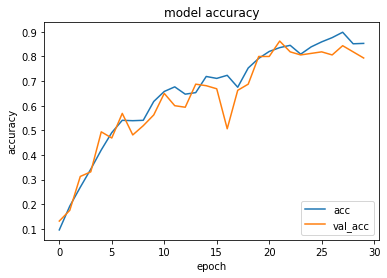

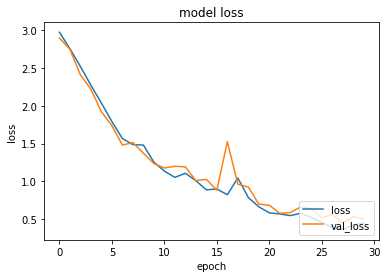

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    # print(history.history.keys())

    # 精度の履歴をプロット
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()

plot_history(h)

In [17]:
# 学習結果を保存する
hdf5_file = os.path.join(base_dir, '../LSTM.hdf5')
model.save(hdf5_file)